# Mode shape magnification

In this example, the usage of the postprocessing module for mode shape magnification is presented.

The data set, used in this showcase is derived from the high-speed camera video of a vibrating beam, as presented in:

Čufar, K., Slavič, J., & Boltežar, M. (2024). Mode-shape magnification in high-speed camera measurements. Mechanical Systems and Signal Processing, 213, 111336. https://doi.org/10.1016/J.YMSSP.2024.111336

Here, the original dataset was decimated by a factor of 50, resulting in a one-second long video with a recording rate of 2000 frames per second (FPS). Additionaly, the color depth was reduced to 8-bit and the background areas of the images were trimmed.

These steps were taken to meet GitHubs file-size limit of 100 MB. For the original recording (20.5 GB) please contact dr. Janko Slavič: janko.slavic@fs.uni-lj.si


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pyidi
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Displacement identification

In the first step, a standard pyIDI displacement identification is performed.

In [2]:
# Specify the ".cih" file that has the same name as the ".mraw" file

filename = 'data/Speckle_beam_2k.cih'

# Make an instance of "pyIDI" class

video = pyidi.pyIDI(filename)

# Create a reference image from the first 10 frames

reference_image = np.average(video.mraw[:10], axis=0)

# Calculate image intensity gradients on the reference image

grad_0, grad_1 = np.gradient(reference_image)

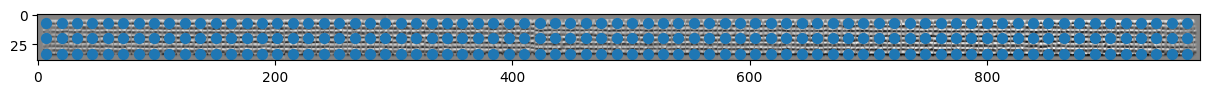

In [3]:
# Deffine the coordinates of the points where displacement will be calculated

y_coord = np.array([7, 20, 33])
x_coord = np.arange(7, 980, 13, dtype=int)

koord_p = np.meshgrid(x_coord, y_coord)
koord_p = np.vstack((koord_p[1].flatten(), koord_p[0].flatten())).T

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(grad_0, 'gray')
ax.scatter(koord_p[:, 1], koord_p[:, 0], s = 50)

In [4]:
# Perform image-based displacement identification

video.set_points(points = koord_p)
video.set_method('sof')

video.method.configure(subset_size = 7, 
                       mean_n_neighbours = 1, 
                       convert_from_px = 0.5/970)  # 0.5 m is equal to 970 px

displacements = video.get_displacements()

100%|██████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.24it/s]

Averaging...
Finished!


### Deflection shape identification

Next, the identified displacements are transformed into the frequency domain. Only the first two modes can be observed as a result of the reduced recording rate.

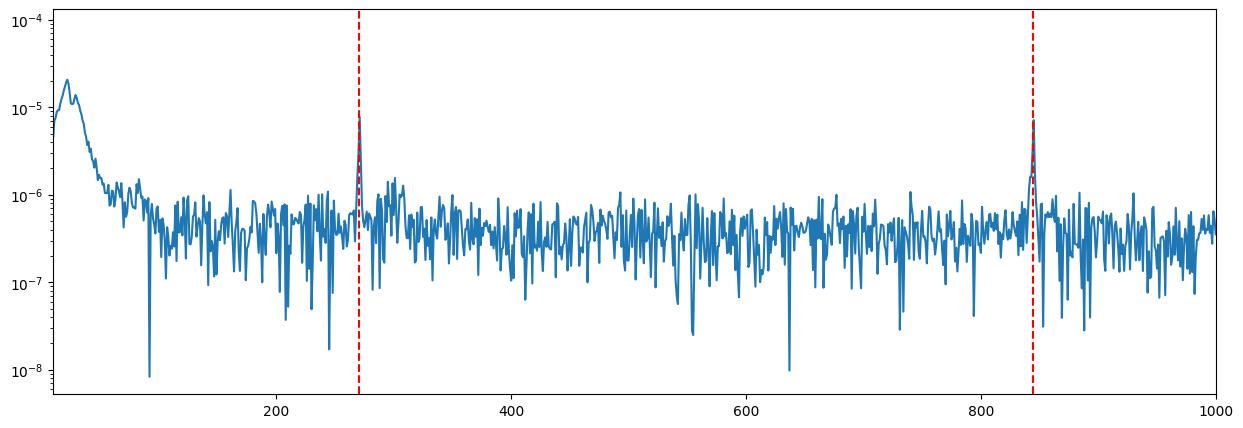

In [5]:
fft = 2 * np.fft.rfft(displacements, axis = 1) / 2000
frq = np.fft.rfftfreq(displacements.shape[1], d = 1 / 2000)

fig, ax = plt.subplots(figsize=(15, 5))
ax.semilogy(frq, np.abs(fft[0, :, 0]))
plt.xlim(10, 1000)

plt.axvline(270, color = 'r', linestyle = '--')
plt.axvline(844, color = 'r', linestyle = '--')

### Magnification

Finally, mode-shape magnification is performed. For simplicity, an operational defelection shape is used here.

(-0.5, 1005.5, 74.5, -0.5)

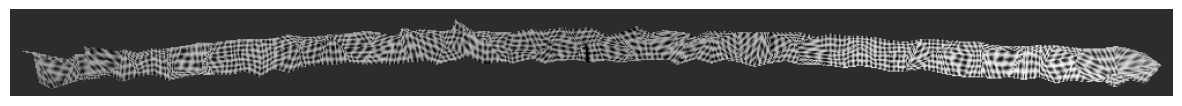

In [6]:
deflection_shape = np.real(fft[:, 270, :])

res = pyidi.postprocessing.mode_shape_magnification(video = video, 
                                                    displacements = deflection_shape, 
                                                    magnification_factor = 4e6,
                                                    background_brightness = 0.5,
                                                    show_undeformed=False)


fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(res, 'gray')
ax.axis('off')

### Generating a video of magnifed mode-shape

A video of the magnified mode shape can also be produced.

In [7]:
# pyidi.postprocessing.animate(displacements = deflection_shape,
#                              magnification_factor = 4e6,
#                              image = reference_image,
#                              points = koord_p,
#                              fps = 30,
#                              n_periods = 5,
#                              filename = 'my_folder/my_video',
#                              output_format = 'gif',
#                              background_brightness = 0.5)